# <span style="color:black">Elevate Midlands’ Air Quality</span> **[21 points]**

## <span style="color:darkergray">Assessing levels of harmful air particulates (PM2.5) in Columbia, SC and its eleven comparative cities, as identified by the Midlands Business Leadership Group (MBLG) </span>

<img src="images/Columbia Skyline.jpg" width=1000 height=100>

This notebook is adapted from the GEOL 365 final project of Ashley Ford who graduated from USC in 2023.

## <span style="color:darkergray">Background</span>

The Midlands Business Leadership Group (MBLG) releases an annual report, known as [Elevate Midlands](https://www.elevatemidlands.com/#latest-report), <span style="color:darkergray; font-weight: bold">that ranks Columbia, South Carolina amongst eleven comparative cities</span> across a series of economic metrics, such as: Entrepreneurship, Innovative Capacity, Industry Clusters, Talent Acquisition & Retention, Liveability, and Employment. The report is often referenced by local leaders as they collaboratively propose and/or implement initiatives to improve the city of Columbia. The overarching goal is to ensure a strong economy by doing things that attract or retain top talent. If people can live, learn, work, and play in Columbia, SC they, their talents, and their incomes will remain here.  


<img src="images/Capture.PNG" width=500>


<span style="color:darkergray; font-weight: bold">These economic metrics depend on the health and well-being of a city’s residents, yet they are infrequently discussed or highlighted.</span> This means there could be an opportunity for Columbia to further differentiate itself from comparative cities by proactively measuring and reporting environmental conditions, such as air quality.

Particulate Matter 2.5 (PM2.5) refers to tiny particles or droplets in the air that are <= 2.5 microns in diameter. They often contain pollutants that can be inhaled, reaching deep into the lungs. <span style="color:darkergray; font-weight: bold">Long-term exposure to elevated PM2.5 levels can lead to adverse health effects like respiratory and cardiovascular problems.</span>  
<img src="images/pm-2.5.jpg" width=500 height=10>


## <span style="color:darkergray">Goals</span>
Determine if there is an opportunity for Columbia, SC to differentiate itself as a ‘clean air city' relative to its eleven economically comparative cities. Simultaneously, identify periods when it may be advantageous for Columbia, SC residents to wear respiratory protection outdoors.  


## <span style="color:darkergray">Significance</span>
By framing pollutants in the context of Columbia, South Carolina’s ability to compete economically with comparative cities, air quality and other environmental factors could eventually be considered critical to the city’s long-term growth. As younger, more mobile generations decide where to live, learn, work, and play, they are likely to incorporate environmental factors into their decision. 


## <span style="color:darkergray">Approach</span>

1. Import relevant data sources. 

2. Prepare the data for processing

3. Test hypothesis that Columbia, SC has cleaner air than most of its comparative cities, using A/B testing to compare the different populations.  

4. Produce clear, effective data visualizations that depict the results. 

4. Document the research in a well-formatted Jupyter notebook. 


## <span style="color:darkergray">1. Import the packages</span>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

## <span style="color:darkergray">2. Prepare the data</span>



There are <span style="color:darkergray; font-weight: bold">two levels</span> of data used for this research: Annual and daily. The <span style="color:darkergray; font-weight: bold">annual</span> data consists of 17 files spanning 2000-2016 (one for each year). It will be used to identify differences between Columbia, SC and its comparative cities. The <span style="color:darkergray; font-weight: bold">daily</span> data consists of 365 files spanning the most recent year of the dataset (2016). It will be used to identify potential trends in air quality within Columbia, SC. Both datasets were provided by data.gov, and may be found [here](https://catalog.data.gov/dataset/daily-and-annual-pm2-5-o3-and-no2-concentrations-at-zip-codes-for-the-contiguous-u-s-2000--c71ab).

<span style="color:darkergray; font-weight: bold">Before we begin, let's take a quick look at an example of each file type.</span> 

You'll notice that the zip code data is incorrect. Also, there is currently no field that stores the date the data was reported. This information is only in the filename. We'll have to address both issues in the upcoming steps.

In [2]:
daily_example = pd.read_csv('./data/Air_Quality_Daily/20160102.rds.csv', engine="python")
daily_example.head()

,ZIP,pm25,STATE
0,12,1.767498,CA
1,14,2.983233,AZ
2,15,1.198228,AZ
3,16,1.624639,CA
4,17,0.762233,CA



<span style="color:darkergray; font-weight: bold">Now, we will combine all annual files and all daily files.</span> 

In [3]:
#Assign the file path location, indicating where each set of files is stored
path_daily='data/Air_Quality_Daily/'

#For each file located at the given path, that ends with .csv, 
#ask the operating system to add the file to a list.
csv_files_daily = [file for file in os.listdir(path_daily) if file.endswith('.csv')]

#Create empty dataframes in which to store concatenated files.
daily_data=[]
  
for csv_file in csv_files_daily:                    #For every csv_file added to the above lists
    file_path = os.path.join(path_daily, csv_file)  #Create a full file path by combining the directory path with the file name
    df = pd.read_csv(file_path, dtype={'ZIP': str}, engine="python") #Read the file; using dtype to ensure the leading zeroes are not dropped from the zip code
    df['FileName']=os.path.splitext(csv_file)[0]    #Grab the filename and store it in a new variable called 'FileName'
    daily_data.append(df)                           #Append the dataframe containing the new field to daily_data
    
#Reassign index values to the new dataframes. This is necessary because we just concatenated/unioned 
#the above tables into a single dataframe. The index values will be wrong otherwise.
daily_data = pd.concat(daily_data, ignore_index=True)


<span style="color:darkergray; font-weight: bold">Let's add a new date field, so we can do a time series analysis later.</span> 

In [4]:
#Drop excess characters from 'FileName' and transform the result to a date value.
#The FileName field was added specifically to extract a date value that can be used later.
daily_data['Date']=daily_data['FileName'].str[:8] 
daily_data['Date']=pd.to_datetime(daily_data['Date'])


#### <span style="color:darkergray">Next, let's limit the datasets to Columbia, SC and comparative cities</span>.

We're only going to compare Columbia to two other cities:

1. Augusta, GA
2. Charleston, SC

Since the air quality dataset does not contain city names or city codes, zip codes must be used to back-in to the city name. Zip codes for these eleven cities, as well as Columbia, SC, were downloaded from https://www.unitedstateszipcodes.org and stored in an Excel file called 'Zip Codes by City.csv.' 

In order to eventually map this data, I required longitude and latitude coordinates. While there are other, more sophisticated ways to obtain polygon map files for zip codes, I opted to use a simpler method in the interest of time. I did a bulk upload of the 'Zip Codes by City.csv' file to [Geocodio](https://www.geocod.io/bulk-convert-zip-codes-to-coordinates/) and retrieved all latitude and longitude coordinates associated with both the center of each zip code and each city center, stored in columns 'lat', 'lon' and 'city_lat', 'city_lon' respectively.

In [5]:
#Read the zip code file from this path
zips=pd.read_csv('./data/ZipCodesbyCity.csv')

#Convert the Zip Code field to an object (necessary for next step)
zips['Zip Code']=zips['original_Zip Code'].astype('str')

#Perform an inner join on these datasets where the zip codes match.
combined_data_daily=pd.merge(daily_data,zips, left_on='ZIP', right_on='Zip Code', how='inner')

#Drop zip codes where no latitude or longitude was found.
#This was determined to be zip codes associated with PO Boxes.
combined_data_daily=combined_data_daily[combined_data_daily['lat']!=' ']

In [6]:
combined_data_daily.describe()

,pm25,Date,original_Zip Code,city_lat,city_lon,lat,lon,name,postcode,confidence,confidence_city_level
count,55146.000000,55146,55146.000000,55146.000000,55146.000000,42224.000000,42224.000000,182.0,33488.000000,33488.0,33488.0
mean,7.833119,2016-03-31 12:00:00.000000256,31118.465347,35.490291,-81.355904,35.386009,-81.249700,30903.0,31314.657609,1.0,1.0
min,0.207118,2016-01-01 00:00:00,23173.000000,30.438200,-85.309677,29.799193,-85.382572,30903.0,23173.000000,1.0,1.0
25%,5.393261,2016-02-15 00:00:00,27499.000000,34.000710,-84.280600,34.019150,-83.988571,30903.0,27602.750000,1.0,1.0
50%,7.326820,2016-03-31 12:00:00,29290.000000,35.779600,-81.034813,35.808730,-81.034702,30903.0,29422.500000,1.0,1.0
75%,9.837105,2016-05-16 00:00:00,37414.000000,37.540700,-78.638200,36.140604,-78.720420,30903.0,37410.250000,1.0,1.0
max,26.120425,2016-06-30 00:00:00,40598.000000,38.040600,-77.436000,38.105239,-77.324555,30903.0,40575.000000,1.0,1.0
std,3.216382,NaN,5512.798194,1.931098,2.624565,1.910606,2.567730,0.0,5316.219011,0.0,0.0


In [7]:
combined_data_daily=combined_data_daily[combined_data_daily['original_Type']!="PO Box"]
print(combined_data_daily.head())

     ZIP      pm25 STATE      FileName       Date  original_Zip Code  \
0  23173  8.967390    VA  20160130.rds 2016-01-30              23173   
2  23219  9.076482    VA  20160130.rds 2016-01-30              23219   
3  23220  9.217615    VA  20160130.rds 2016-01-30              23220   
4  23221  9.255383    VA  20160130.rds 2016-01-30              23221   
5  23222  8.588715    VA  20160130.rds 2016-01-30              23222   

  original_Type original_City  city_lat  city_lon  ...     state  state_code  \
0        Unique      Richmond   37.5407   -77.436  ...  Virginia          VA   
2      Standard      Richmond   37.5407   -77.436  ...  Virginia          VA   
3      Standard      Richmond   37.5407   -77.436  ...  Virginia          VA   
4      Standard      Richmond   37.5407   -77.436  ...  Virginia          VA   
5      Standard      Richmond   37.5407   -77.436  ...  Virginia          VA   

         country  country_code  confidence confidence_city_level  \
0  United States  

## <span style="color:darkergray">3. Test hypothesis that Columbia, SC has cleaner air than most of its comparative cities, using A/B testing to compare the different populations</span>

Now that the data has been gathered and modified to fit our needs, it's time to begin our analysis.

### <span style="color:darkergray">3.a. Investigate the daily data from 2016 (most recent year) to familiarize ourselves with it</span>

<font color=goldenrod>**_Code for you to write_**</font> **[1 point]**
- Trim `combined_data_daily` to each only contain columns `original_City` and `pm25`

In [8]:
combined_data_daily_trimmed = combined_data_daily[["original_City","pm25"]]
combined_data_daily_trimmed.head()

,original_City,pm25
0,Richmond,8.967390
2,Richmond,9.076482
3,Richmond,9.217615
4,Richmond,9.255383
5,Richmond,8.588715


<font color=goldenrod>**_Code for you to write_**</font> **[2 points]**
- Create a kdeplot of `pm25` from the `combined_data_daily` dataframe
- Add labels and a title

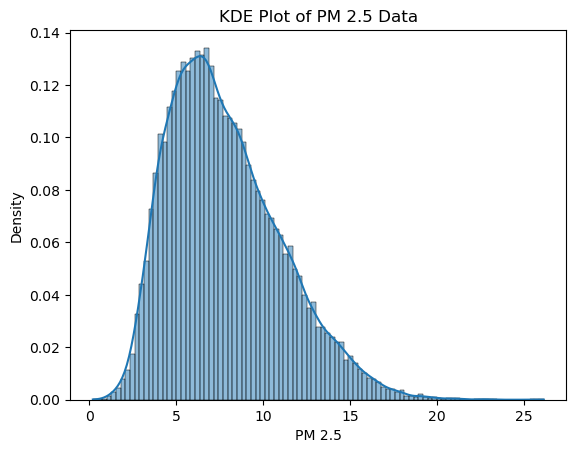

In [9]:
sns.histplot(combined_data_daily_trimmed["pm25"], kde=True, stat="density")
plt.title("KDE Plot of PM 2.5 Data")
plt.xlabel("PM 2.5")
plt.show()

In [10]:
combined_data_daily = combined_data_daily_trimmed
combined_data_daily.describe()

,pm25
count,36400.000000
mean,7.824855
std,3.221556
min,0.207118
25%,5.383038
50%,7.319265
75%,9.835317
max,26.120425


We can see that most of the PM 2.5 values for 2016 are near 8 ppm, but there are outliers as high as 136. This lets us view upcoming statistics through a lens of reality. We will know what values are realistic.

### <span style="color:darkergray">3.b. Compare the total PM 2.5 (ppm) from 2016 for each city to identify potential trends or relationships</span>

We can do this a few ways. Let's start by making a violin plot. That should make the outliers more visible.

<font color=goldenrod>**_Code for you to write_**</font> **[1 points]**
- Create a violin plot of `pm25` from the `combined_data_daily` dataframe for Columbia, Charleston, and Augusta

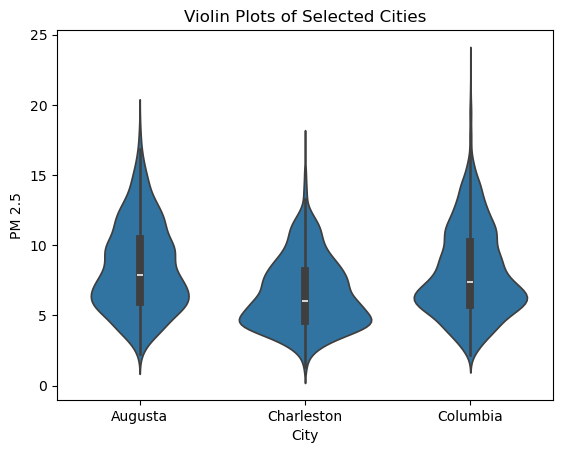

In [11]:
sns.violinplot(x="original_City", y="pm25", data=combined_data_daily[combined_data_daily["original_City"].isin(["Augusta", "Charleston","Columbia"])], order=["Augusta", "Charleston","Columbia"])
plt.title("Violin Plots of Selected Cities")
plt.xlabel("City")
plt.ylabel("PM 2.5")
plt.show()

We can see that many cities have experienced days of extremely poor air quality. However, it is difficult to compare the cities to one another in this violin plot. 

Let's try a **bar chart** use to put these amounts of PM 2.5 in perspective using `plt.bar`. `plt.bar` takes arguments of a **list** of labels, such as `['label1', 'label2' ..., 'labeln']` and then a **list** of the bar height. In this case, your list of labels will be the city names, and the list of bar heights will be the mean values you calculate.


<font color=goldenrod>**_Code for you to write_**</font> **[4 points]**
- Use a for loop to calculate the mean `pm25` from `combined_data_daily` for each of the three cities, Columbia, and Charleston, Augusta <font color=blue>**_Hint_**</font> use a mask to select the data from each city
- Append each value to a list
- Use `plt.bar` to plot the mean values
- Add a ylabel and a title
- The mean values should be: Columbia=8.1, Charleston=6.5, Augusta=8.4

[np.float64(8.381952867281905), np.float64(6.540797419438182), np.float64(8.060882583535724)]


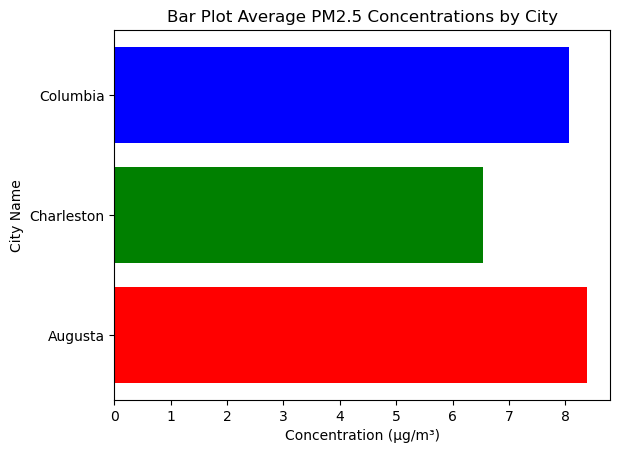

In [12]:
mean_pm25_per_city=[]
cities = ["Augusta", "Charleston","Columbia"]
city_colors = ['red', 'green', 'blue']

for city in cities:
    mean_val = np.mean(combined_data_daily[combined_data_daily["original_City"]==city]["pm25"])
    mean_pm25_per_city.append(mean_val)

print(mean_pm25_per_city)

plt.barh(y=cities, width=mean_pm25_per_city, color=city_colors, mouseover=True)
plt.title("Bar Plot Average PM2.5 Concentrations by City")
plt.ylabel("City Name")
plt.xlabel(r'Concentration (µg/m³)')
# plt.ylabel(r"PM 2.5 - Concentration ($ \\mu$g/L)")
# plt.grid()
plt.show()



In [13]:
plt.bar?

Signature:
plt.bar(
    x: 'float | ArrayLike',
    height: 'float | ArrayLike',
    width: 'float | ArrayLike' = 0.8,
    bottom: 'float | ArrayLike | None' = None,
    *,
    align: "Literal['center', 'edge']" = 'center',
    data=None,
    **kwargs,
) -> 'BarContainer'
Docstring:
Make a bar plot.

The bars are positioned at *x* with the given *align*\ment. Their
dimensions are given by *height* and *width*. The vertical baseline
is *bottom* (default 0).

Many parameters can take either a single value applying to all bars
or a sequence of values, one for each bar.

Parameters
----------
x : float or array-like
    The x coordinates of the bars. See also *align* for the
    alignment of the bars to the coordinates.

    Bars are often used for categorical data, i.e. string labels below
    the bars. You can provide a list of strings directly to *x*.
    ``bar(['A', 'B', 'C'], [1, 2, 3])`` is often a shorter and more
    convenient notation compared to
    ``bar(range(3), [1, 2, 3], ti

GENERAL OBSERVATIONS: These histograms and horizontal bar charts are helpful when you first begin to investigate a dataset. We learned some good news: all cities were well below the World Health Organization's recommendation of 15 ppm.


### <span style="color:darkergray">3.c. Using the 2016 (daily) dataset, conduct a series of A/B tests that compare the PM 2.5 levels of Columbia, SC to the comparative cities</span>

In modern data analytics, deciding whether two numerical samples come from the same underlying distribution is called A/B testing. The name refers to the labels of the two samples, A and B.

<span style="color:darkergray; font-weight: bold">The Hypotheses</span>

The chance model that we will test says that there is no underlying difference in the popuations; the distributions in the samples are different just due to chance. Formally, this is the null hypothesis. The alternative hypothesis implies that there is a significant difference in PM 2.5 between Columbia, SC and the city to which it is being compared. 

<span style="color:darkergray; font-weight: bold">Build the two-city dataframes</span>

<font color=goldenrod>**_Code for you to write_**</font> **[4 points]**
- Create a dataframe containing two cities (Columbia and Charleston)
- Reset the indices using `dataframe_name.reset_index(inplace=True)`
- Create a dataframe containing two cities (Columbia and Augusta)
- Reset the indices using `dataframe_name.reset_index(inplace=True)`

In [14]:
# Using airport codes for city names

cae_chs = combined_data_daily[combined_data_daily["original_City"].isin(["Columbia", "Charleston"])]
cae_chs.reset_index(inplace=True)

cae_ags = combined_data_daily[combined_data_daily["original_City"].isin(["Columbia", "Augusta"])]
cae_ags.reset_index(inplace=True)

print(cae_chs["original_City"].unique())
print(cae_ags["original_City"].unique())

['Columbia' 'Charleston']
['Columbia' 'Augusta']


<span style="color:darkergray; font-weight: bold">Determine a test statistic and calculate it.</span>

The <span style="color:darkergray; font-weight: bold">difference of the means</span> and <span style="color:darkergray; font-weight: bold">difference of the medians</span> will be our test statistics, and we'll use functions to calculate them.

In [15]:
def difference_of_means(dataframe,category_column,category_values_1,category_values_2,value):
    '''
    Function to calculate the difference of mean from a dataframe.
    
    Parameters
    ----------
    dataframe : the pandas dataframe containing the data
    value : the column for which the mean will be calculated (a string)
    category_column : the column that will be used to categorize the data (a string)
    category_values : the values of the category (a list of strings)
    '''
    mean_1 = np.mean(dataframe[dataframe[category_column]==category_values_1][value])
    mean_2 = np.mean(dataframe[dataframe[category_column]==category_values_2][value])
    
    return mean_1 - mean_2

def difference_of_medians(dataframe,category_column,category_values_1,category_values_2,value):
    '''
    Function to calculate the difference of median from a dataframe.
    
    Parameters
    ----------
    dataframe : the pandas dataframe containing the data
    value : the column for which the mean will be calculated (a string)
    category_column : the column that will be used to categorize the data (a string)
    category_values : the values of the category (a list of strings)
    '''
    median_1 = np.median(dataframe[dataframe[category_column]==category_values_1][value]) #1st variable is passed '0'
    median_2 = np.median(dataframe[dataframe[category_column]==category_values_2][value]) #2nd variable is passed '1'
    
    return median_1 - median_2

<font color=goldenrod>**_Code for you to write_**</font> **[2 points]**
- Apply `difference_of_means` to the Columbia and Charleston dataset and save the difference of means to a variable
- Apply `difference_of_medians` to the Columbia and Charleston dataset and save the difference of medians to a variable
- Apply `difference_of_means` to the Columbia and Augusta dataset and save the difference of means to a variable
- Apply `difference_of_meadias` to the Columbia and Augusta dataset and save the difference of medians to a variable
- The difference of means and medians for Columbia and Charleston should be: -1.52 and -1.31, and for Columbia and Augusta should be: 0.32 and 0.52

In [16]:
#Send the values from each of the two-city datasets through the function to acquire the mean and median differences.
ColaCharleston_mean_diff = difference_of_means(cae_chs, "original_City", "Charleston", "Columbia", "pm25")
ColaCharleston_median_diff = difference_of_medians(cae_chs, "original_City", "Charleston", "Columbia", "pm25")
print (ColaCharleston_mean_diff,ColaCharleston_median_diff)

ColaAugusta_mean_diff = difference_of_means(cae_ags, "original_City", "Augusta", "Columbia", "pm25")
ColaAugusta_median_diff = difference_of_medians(cae_ags, "original_City", "Augusta", "Columbia", "pm25")
print (ColaAugusta_mean_diff,ColaAugusta_median_diff)

-1.5200851640975417 -1.3139739842120646
0.32107028374618096 0.526195406341726


#### <span style="color:darkergray">Test the null hypothesis through random permutation.</span>

If there was no difference between the two distributions in the underlying population, then whether the city is Columbia or any other city should make no difference to the average. We will shuffle all the labels randomly among the PM 2.5 values within each of the 11 two-city datasets. This is called random permutation. 

#### <span style="color:darkergray">Repeat the process many times using a function.</span>

The above difference is the result of one random permutation. We want to do many random permutations to test the hypothesis.

<font color=goldenrod>**_Code for you to write_**</font> **[2 points]**
- Complete the code below for the **Columbia and Charleston** dataframe
- Run 1000 repetitions
- Shuffle the `'original_City'` column and save as a new column called `'City Shuffled'`
- Calculate the shuffled difference of means
- Append the value to the empty dataframe
- Calculate the shuffled difference of medians
- Append the value to the empty dataframe

**Ignore warnings about `A value is trying to be set on a copy of a slice from a DataFrame.`**

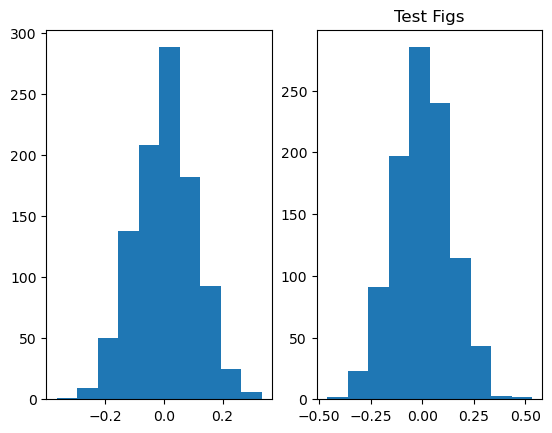

In [17]:
%%capture --no-display

#Create a series of 'placeholders' for the output
dif_permutations_ColaCharleston_mean = []
dif_permutations_ColaCharleston_median = []

def shuffle():
    combined_data_daily['City Shuffled'] = np.random.permutation(combined_data_daily['original_City'].values)

for i in range(1000):
    shuffle()
    dif_permutations_ColaCharleston_mean.append(difference_of_means(combined_data_daily, "City Shuffled", "Charleston", "Columbia", "pm25"))
    dif_permutations_ColaCharleston_median.append(difference_of_medians(combined_data_daily, "City Shuffled", "Charleston", "Columbia", "pm25"))

fig, axes = plt.subplots(1, 2)
axes[0].hist(dif_permutations_ColaCharleston_mean)
axes[1].hist(dif_permutations_ColaCharleston_median)
plt.title("Test Figs")
plt.show()

<font color=goldenrod>**_Code for you to write_**</font> **[2 points]**
- Complete the code below for the **Columbia and Augusta** dataframe
- Run 1000 repetitions
- Shuffle the `'original_City'` column and save as a new column called `'City Shuffled'`
- Calculate the shuffled difference of means
- Append the value to the empty dataframe
- Calculate the shuffled difference of medians
- Append the value to the empty dataframe

**Ignore warnings about `A value is trying to be set on a copy of a slice from a DataFrame.`**

In [18]:
%%capture --no-display

#Create a series of 'placeholders' for the output
dif_permutations_ColaAugusta_mean = []
dif_permutations_ColaAugusta_median = []

for i in range(1000):
    shuffle()
    dif_permutations_ColaAugusta_mean.append(difference_of_means(combined_data_daily, "City Shuffled", "Augusta", "Columbia", "pm25"))
    dif_permutations_ColaAugusta_median.append(difference_of_medians(combined_data_daily, "City Shuffled", "Augusta", "Columbia", "pm25"))



#### <span style="color:darkergray">Now, let's look at the results.</span>

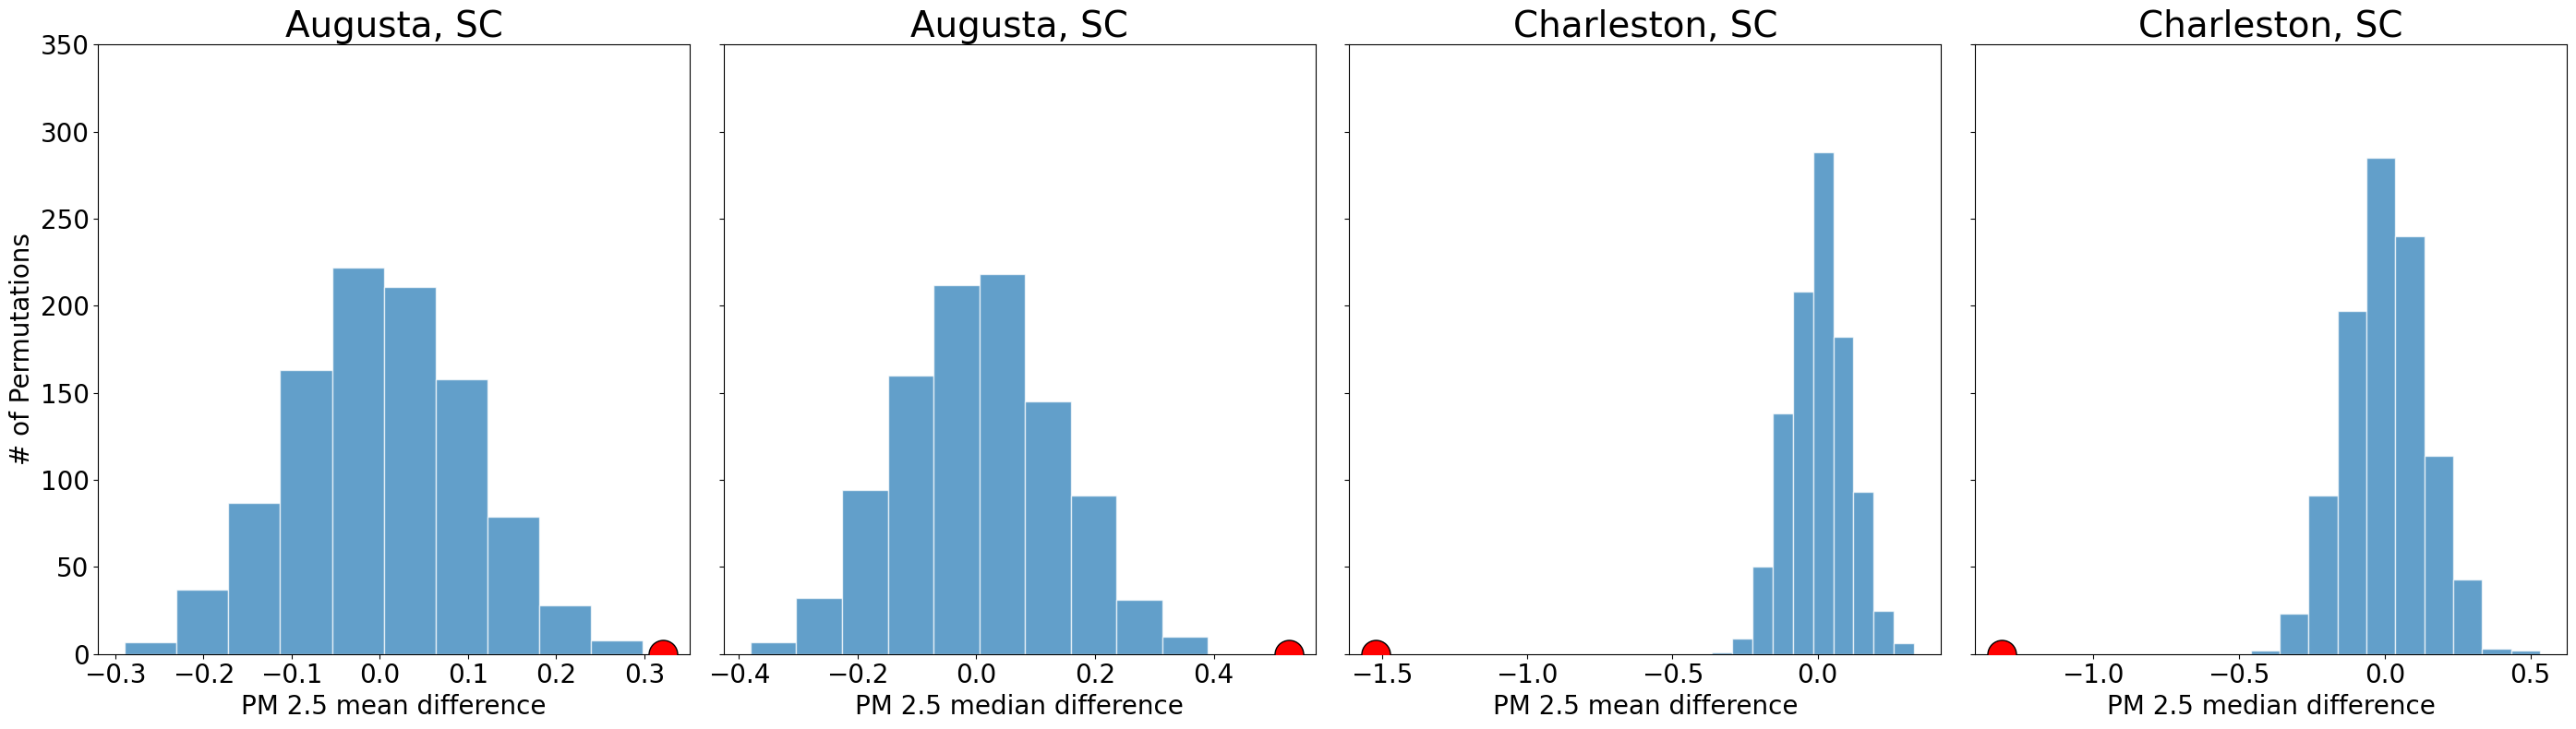

In [19]:
#ROW 1
fig, axes = plt.subplots(1,4, figsize=(28, 8), sharey=True)
ax1, ax2, ax3, ax4= axes

#Columbia & Augusta
ax1.hist(dif_permutations_ColaAugusta_mean,label='permutations', alpha=.7, edgecolor='white')
ax1.scatter(ColaAugusta_mean_diff,0,color='red', edgecolor= 'black', s=500, zorder=1000,label='actual')
ax1.set_xlabel('PM 2.5 mean difference', fontsize=20)
ax1.set_ylabel('# of Permutations', fontsize=20)
ax1.set_ylim(0,350)
ax1.tick_params(axis='both', labelsize=20)
ax1.set_title('Augusta, SC', fontsize=28)

ax2.hist(dif_permutations_ColaAugusta_median,label='permutations', alpha=.7, edgecolor='white')
ax2.scatter(ColaAugusta_median_diff,0,color='red', edgecolor= 'black', s=500, zorder=1000,label='actual')
ax2.set_xlabel('PM 2.5 median difference', fontsize=20)
ax2.set_ylim(0,350)
ax2.tick_params(axis='both', labelsize=20)
ax2.set_title('Augusta, SC', fontsize=28)
#plt.legend(fontsize=20, markerscale=0.5)

#Columbia & Charleston
ax3.hist(dif_permutations_ColaCharleston_mean,label='permutations', alpha=.7, edgecolor='white')
ax3.scatter(ColaCharleston_mean_diff,0,color='red', edgecolor= 'black', s=500, zorder=1000,label='actual')
ax3.set_xlabel('PM 2.5 mean difference', fontsize=20)
ax3.set_ylim(0,350)
#ax3.set_ylabel('# of Permutations', fontsize=20)
ax3.tick_params(axis='both', labelsize=20)
ax3.set_title('Charleston, SC', fontsize=28)

ax4.hist(dif_permutations_ColaCharleston_median,label='permutations', alpha=.7, edgecolor='white')
ax4.scatter(ColaCharleston_median_diff,0,color='red', edgecolor= 'black', s=500, zorder=1000,label='actual')
ax4.set_xlabel('PM 2.5 median difference', fontsize=20)
ax4.tick_params(axis='both', labelsize=20)
ax4.set_ylim(0,350)
ax4.set_title('Charleston, SC', fontsize=28)
#plt.legend(fontsize=20, markerscale=0.5)
plt.tight_layout()
plt.show()

All distributions are centered around 0, because under the null hypothesis the two groups should have roughly the same average. Therefore, the difference between the group averages should be around 0.

#### <span style="color:darkergray">Next, calculate the p-value. This will help us determine if there is enough difference between the permutations and the actual mean and medians to reject the null hypothesis.</span>

<font color=goldenrod>**_Code for you to write_**</font> **[2 points]**
- Calculate the `mean_empirical_p` for the Columbia and Charleston dataframe
- Calculate the `median_empirical_p` for the Columbia and Charleston dataframe
- Calculate the `mean_empirical_p` for the Columbia and Augusta dataframe
- Calculate the `median_empirical_p` for the Columbia and Augusta dataframe

In [35]:
repetitions = 1000
mean_empirical_p_ColaCharleston = np.count_nonzero(dif_permutations_ColaCharleston_mean <= ColaCharleston_mean_diff) / repetitions
median_empirical_p_ColaCharleston = np.count_nonzero(dif_permutations_ColaCharleston_median <= ColaCharleston_median_diff) / repetitions
mean_empirical_p_ColaAugusta = np.count_nonzero(dif_permutations_ColaAugusta_mean <= ColaAugusta_mean_diff) / repetitions
median_empirical_p_ColaAugusta = np.count_nonzero(dif_permutations_ColaAugusta_median <= ColaAugusta_median_diff) / repetitions


In [36]:
print('MEAN Empirical P-Values', '              ''MEDIAN Empirical P-Values', '   ')
print('')
print('Charleston, SC:\t\t ', round(mean_empirical_p_ColaCharleston,2), '       ', round(median_empirical_p_ColaCharleston,2))
print('Augusta, SC:\t\t ', round(mean_empirical_p_ColaAugusta,2), '       ', round(median_empirical_p_ColaAugusta,2))

MEAN Empirical P-Values               MEDIAN Empirical P-Values    

Charleston, SC:		  0.0         0.0
Augusta, SC:		  1.0         1.0


In [37]:
# using absolute values to treeat the differences as equals. 
abs_ColaCharleston_mean_diff = np.abs(ColaCharleston_median_diff)
abs_ColaCharleston_median_diff = np.abs(ColaCharleston_median_diff)
abs_ColaAugusta_mean_diff = np.abs(ColaAugusta_mean_diff)
abs_ColaAugusta_median_diff = np.abs(ColaAugusta_median_diff)

repetitions = 1000

mean_empirical_p_ColaCharleston_two_sided = np.count_nonzero(np.abs(dif_permutations_ColaCharleston_mean) >= abs_ColaCharleston_mean_diff) / repetitions

median_empirical_p_ColaCharleston_two_sided = np.count_nonzero(np.abs(dif_permutations_ColaCharleston_median) >= abs_ColaCharleston_median_diff) / repetitions

mean_empirical_p_ColaAugusta_two_sided = np.count_nonzero(np.abs(dif_permutations_ColaAugusta_mean) >= abs_ColaAugusta_mean_diff) / repetitions
median_empirical_p_ColaAugusta_two_sided = np.count_nonzero(np.abs(dif_permutations_ColaAugusta_median) >= abs_ColaAugusta_median_diff) / repetitions

In [38]:
print('MEAN Empirical P-Values', '              ''MEDIAN Empirical P-Values', '   ')
print('')
print('Charleston, SC:\t\t ', round(mean_empirical_p_ColaCharleston_two_sided,2), '       ', round(median_empirical_p_ColaCharleston_two_sided,2))
print('Augusta, SC:\t\t ', round(mean_empirical_p_ColaAugusta_two_sided,2), '       ', round(median_empirical_p_ColaAugusta_two_sided,2))

MEAN Empirical P-Values               MEDIAN Empirical P-Values    

Charleston, SC:		  0.0         0.0
Augusta, SC:		  0.0         0.0


<font color=red>**_Question_**</font> **[1 point]** Based on the p-values above, can we reject the null hypothesis with greater than 95% confidence that the two cities have the same air pollution for either Columbia and Charleston or Columbia and Augusta?

**Write your answer below**

**__Null Hypothesis__**: the distributions in the samples are different just due to chance.

These results are a little confusing because we are running a one-sided test. Checking to see in how many random permutations another city's pm2.5 - columbia is greater than the average difference of another city - columbia's pm2.5 can cause some issues. 

With a one sided test, we had an approximate p-value of 1 for charleston and 0 for Augusta, meaning we did not have enough evidence to reject the null in Charleston, but did have enought in Augusta. 

However, if we run a two-sided test, we can see that both values are near 0, so we would reject both values and say it is not up to random chance that their pm 2.5 concentrations are different. 